In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt

### Uniform distibution 

In [3]:
from datasets import ArtificialDataset_NonLin
from cross_moment import get_beta

### Performance & Transformation Scale

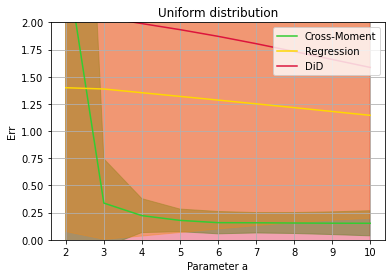

In [4]:
dist_name = "Uniform"
seed = 1999
deg = 3
n_exp = 10
min_scale = 2
step_scale = 1
max_scale = 11
np.random.seed(seed)

betas_true = np.zeros(n_exp, dtype=float)
betas = {}
betas_reg = {}
betas_did = {}
scale_noise = 0.1
scale_noise_Z = 0.1
n_samples = 10000
for i in range(n_exp):
    seed = np.random.randint(1000)
    alpha_d, alpha_z, beta, gamma = 0, 0, 0, 0
    while abs(alpha_d) < 0.2:
        alpha_d = -2 + 4 * np.random.rand()

    scale = 0
    while abs(scale) < 0.2:
        scale = -2 + 4 * np.random.rand()
        alpha_z = alpha_d * scale

    scale = 0
    while abs(scale) < 0.2:
        scale = -2 + 4 * np.random.rand()
        beta = alpha_d * scale

    scale = 0
    while abs(scale) < 0.5 or abs(scale) > 2:
        scale = -2 + 4 * np.random.rand()
        gamma = alpha_z * scale
        
    betas_true[i] = beta

    for tran_scale in range(min_scale, max_scale, step_scale):
        # Initialize variances randomly
        var_u, var_d, var_z, var_w, var_y = 0, 0, 0, 0, 0
        while var_u < 1/3:
            var_u = 1/3 * 100 * np.random.rand()
        var_d = scale_noise * var_u
        var_z = scale_noise_Z * var_u
        var_y = scale_noise * var_u

        radius_u = np.sqrt(var_u * 12)
        radius_d = np.sqrt(var_d * 12)
        radius_z = np.sqrt(var_z * 12)
        radius_y = np.sqrt(var_y * 12)
        
        dist_param = {
            "U": {"low": -radius_u, "high": radius_u},
            "D": {"low": -radius_d, "high": radius_d},
            "Z": {"low": -radius_z, "high": radius_z},
            "Y": {"low": -radius_y, "high": radius_y},
        }
        dist_conf = (dist_name, dist_param)

        # Get synthetic data
        artific_dataset = ArtificialDataset_NonLin(alpha_z, alpha_d, beta, gamma, n_samples, dist_conf, seed, tran_scale=tran_scale)
        Z = artific_dataset.Z.numpy()
        D = artific_dataset.D.numpy()
        Y = artific_dataset.Y.numpy()

        if tran_scale not in betas.keys():
            betas[tran_scale] = []
        betas[tran_scale].append(get_beta(Z, D, Y, deg))
        
        # Prepare dataset of simple linear regression
        data_tmp = np.concatenate((np.expand_dims(Z, axis=1), np.expand_dims(D, axis=1)), axis=1)

        # Estimate beta with simple linear regression
        reg = LinearRegression().fit(data_tmp, Y)
        if tran_scale not in betas_reg.keys():
            betas_reg[tran_scale] = []
        betas_reg[tran_scale].append(reg.coef_[-1])
        
        # Prepare dataset of DiD estimation
        T_z = np.zeros(len(Z), dtype=np.float32)
        T_y = np.ones(len(Y), dtype=np.float32)
        T = np.concatenate((T_z, T_y))
        D_new = np.concatenate((D, D))
        TD = np.concatenate((T_z, D))
        Y_new = np.concatenate((Z, Y))
        data_did =  np.concatenate((np.expand_dims(T, 1), np.expand_dims(D_new, 1), np.expand_dims(TD, 1)), axis=1)

        # Estimate beta with DiD
        reg = LinearRegression().fit(data_did, Y_new)
        if tran_scale not in betas_did.keys():
            betas_did[tran_scale] = []
        betas_did[tran_scale].append(reg.coef_[-1])
    
# Preprocess data to make a plot
x = list(range(min_scale, max_scale, step_scale))
y = np.zeros(len(x))
yerr = np.zeros(len(x))
y_reg = np.zeros(len(x))
yerr_reg = np.zeros(len(x))
y_did = np.zeros(len(x))
yerr_did = np.zeros(len(x))


for i, tran_scale in enumerate(range(min_scale, max_scale, step_scale)):
    x[i] = tran_scale
    
    estimates = np.abs((np.array(betas[tran_scale]) - betas_true) / betas_true)
    y[i] = np.mean(estimates)
    yerr[i] = np.std(estimates)
    
    estimates = np.abs((np.array(betas_reg[tran_scale]) - betas_true) / betas_true)
    y_reg[i] = np.mean(estimates)
    yerr_reg[i] = np.std(estimates)

    estimates = np.abs((np.array(betas_did[tran_scale]) - betas_true) / betas_true)
    y_did[i] = np.mean(estimates)
    yerr_did[i] = np.std(estimates)

# Plot the results
eps=0.3
plt.title("Uniform distribution")
plt.xlabel("Parameter a")
plt.ylabel("Err")
plt.plot(x, y, label="Cross-Moment", color="limegreen")
plt.fill_between(x, y - yerr, y + yerr, alpha=0.6, color="limegreen")
plt.plot(x, y_reg, label="Regression", color="gold")
plt.fill_between(x, y_reg - yerr_reg, y_reg + yerr_reg, alpha=0.4, color="gold")
plt.plot(x, y_did, label="DiD", color="crimson")
plt.fill_between(x, y_did - yerr_did, y_did + yerr_did, alpha=0.4, color="crimson")
plt.legend(loc="upper right")
plt.grid()
plt.ylim(0, 2)
plt.savefig("./figures/uniform_samples_nonlin_tran.png")
plt.show()